## Treatment T10 Preparation

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb

RND_SEED = 6
np.random.seed = RND_SEED

# DATA_FILE = "../data/t00/data_gen.csv"

TREATMENT = "t00"

# Read and sanitize the data
export_folder = f"../data/output/diagrams/dss"
os.makedirs(export_folder, exist_ok=True)


df = pd.read_csv(f"../data/{TREATMENT}/export/result__{TREATMENT}_prop.csv")
df_full = df.copy()
drop_cols = ["worker_id", "resp_worker_id", "prop_worker_id", "updated", "status", "job_id", "status",
             "timestamp", "rowid", "offer_dss", "offer", "offer_final", "completion_code", "prop_time_spent", "worker_bonus"]
df = df[[col for col in df.columns if col not in drop_cols]]
df = df.dropna()

cols = [col for col in df.columns if col != "min_offer"] + ["min_offer"]
df = df[cols]

## comment/uncomment for shuffling
#df = df.sample(frac=1.0)
TEST_SIZE = 50
df_base = df.copy()

df_train = df.head(df.shape[0] - TEST_SIZE)
df_test = df.tail(TEST_SIZE)


# df_full = pd.read_csv(DATA_FILE)
df_min = df_full.min()
df_max = df_full.max()
df.head()
# print(df_min)
# print(df_max)

,cc_beta,cc_criterion,cc_false_alarm_avg_click_delay,cc_false_alarm_rate,cc_false_alarms,cc_hit_avg_click_delay,cc_hit_rate,cc_hits,cc_sensitivity,cpc_expected_value,...,ras_q9,ras_time_spent,resp_time_spent,risk_expected_value,risk_q1,risk_q2,risk_q3,risk_q4,risk_time_spent,min_offer
0,0.786247,-0.146466,271.0,0.25,1,290.00,0.833333,5,1.641911,9.5323,...,-1,115,11,3.0125,1.05,1.50,3.50,6.00,52,40
1,0.744767,1.266672,0.0,0.00,0,0.00,0.000000,0,-0.232645,9.5323,...,-2,227,12,1.8200,1.04,1.20,2.00,3.04,62,50
2,1.766303,0.359811,0.0,0.00,0,362.75,0.666667,4,1.581077,10.6715,...,2,95,21,1.8200,1.04,1.20,2.00,3.04,39,40
3,0.626283,-0.483711,205.0,0.50,2,232.00,0.833333,5,0.967422,10.2117,...,2,153,8,4.6450,1.09,1.99,5.50,10.00,101,50
4,1.766303,0.790538,0.0,0.00,0,420.00,0.333333,2,0.719622,8.6673,...,3,107,9,2.0350,1.02,1.60,1.53,3.99,18,50


In [2]:
set(df.columns) - set(['cc_beta', 'cc_criterion', 'cc_false_alarm_avg_click_delay', 'cc_false_alarm_rate', 'cc_false_alarms', 'cc_hit_avg_click_delay', 'cc_hit_rate', 'cc_hits', 'cc_sensitivity', 'cpc_expected_value', 'cpc_expected_value_max', 'cpc_expected_value_min', 'cpc_q1', 'cpc_q10', 'cpc_q2', 'cpc_q3', 'cpc_q4', 'cpc_q5', 'cpc_q6', 'cpc_q7', 'cpc_q8', 'cpc_q9', 'cpc_time_spent', 'exp_ultimatum_game_experience', 'ras_assertiveness', 'ras_q1', 'ras_q10', 'ras_q11', 'ras_q12', 'ras_q13', 'ras_q14', 'ras_q15', 'ras_q16', 'ras_q17', 'ras_q18', 'ras_q19', 'ras_q2', 'ras_q20', 'ras_q21', 'ras_q22', 'ras_q23', 'ras_q24', 'ras_q25', 'ras_q26', 'ras_q27', 'ras_q28', 'ras_q29', 'ras_q3', 'ras_q30', 'ras_q4', 'ras_q5', 'ras_q6', 'ras_q7', 'ras_q8', 'ras_q9', 'ras_time_spent', 'risk_expected_value', 'risk_q1', 'risk_q2', 'risk_q3', 'risk_q4', 'risk_time_spent', 'resp_time_spent'])

{'min_offer'}

## Determine significant features

**Feature importance permutation**

In [3]:
from core.utils.preprocessing import df_to_xy, df_to_xydf
from core.models import AcceptanceModel, ClusterExtModel
from core.models.metrics import MAX_GAIN
from core.utils.benchmark import process_model, process_benchmark_cv
from mlxtend.evaluate import feature_importance_permutation

In [4]:
# from sklearn.svm import SVR

# from core.models import AcceptanceModel
# from core.utils.preprocessing import df_to_xy, df_to_xydf
# from core.models.metrics import avg_gain_ratio

# NB_REPETITIONS = 5

# imp_vals = None
# imp_all = None
# for _ in range(NB_REPETITIONS):
#     df_x, df_y = df_to_xydf(df_train.sample(frac=1.0, random_state=RND_SEED), fuse_risk=True)
#     #model = ClusterExtModel(base_model="affinity")
#     model = AcceptanceModel(SVR(gamma='auto', kernel='poly', degree=2), step=10, zero_one=False)
#     split = int(0.6 * df_x.shape[0])
#     model.fit(df_x.values[:split], df_y.values.ravel()[:split])

#     step_imp_vals, step_imp_all = feature_importance_permutation(
#         predict_method=model.predict, 
#         X=df_x.values[split:],
#         y=df_y.values.ravel()[split:],
#         metric=avg_gain_ratio,
#         num_rounds=3,
#         seed=None)
#     if imp_vals is None:
#         imp_vals = step_imp_vals
#         imp_all = step_imp_all
#     else:
#         imp_vals += step_imp_vals
#         imp_all += step_imp_all


# imp_all /= NB_REPETITIONS
# imp_vals /= NB_REPETITIONS
# std = np.std(imp_all, axis=1)
# indices = np.argsort(imp_vals)[::-1]


# plt.figure(figsize=(15, 8))
# plt.title("Feature importance via permutation importance")
# plt.bar(df_x.columns[indices], imp_vals[indices],
#         yerr=std[indices],)
# plt.show()



## Generate data for the survey

**Save the model and model infos**

In [5]:
from core.utils.pipeline import train_and_save
# cols = []
# results = []
# for col in cols:
#     model = ClusterExtModel(base_model="affinity")
#     tm, infos = train_and_save("../data/t00", "../data/t00", model=model, shuffle=True, random_state=RND_SEED, top_columns=[col])
#     results.append(infos)
#     infos['col'] = col
    
# result_df = pd.DataFrame(data=results)
# # result_df.index = result_df['col'].values
# # result_df = result_df[['acc', 'val_acc', 'unique_preds']]

# result_df


In [6]:
# model = ClusterExtModel(base_model="meanshift")
# top_model, infos = train_and_save("../data/t00", "../data/t00", model=model, shuffle=True, random_state=RND_SEED, top_columns=['risk', 'count_effort', 'Honesty_Humility', 'selfish'])
# print("acc:", infos["acc"], "val_acc:", infos["val_acc"], "unique_values:", (infos["unique_preds"]))
# top_model.base_model.cluster_centers_
# top_model.predict(top_model.base_model.cluster_centers_)

In [7]:
from sklearn.svm import SVR, LinearSVR
from core.models import AcceptanceModel, EMModel
model = EMModel()

top_model, infos = train_and_save("../data/t00/export", "../data/t00", model=model, shuffle=True, random_state=RND_SEED, top_columns=[], data_dir_filename=f"data__{TREATMENT}_prop.csv", drop_columns=drop_cols)
print("acc:", infos["acc"], "val_acc:", infos["val_acc"], "unique_values:", (infos["unique_preds"]))

acc: 0.8212135502804325 val_acc: 0.7879122409197598 unique_values: [50.0]


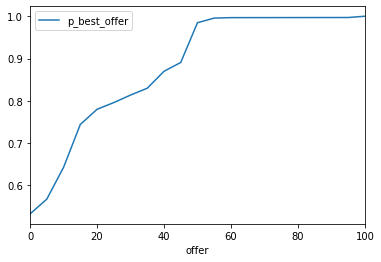

In [8]:
from core.utils.explanation import get_acceptance_probability
offers = list(range(0, MAX_GAIN+5, 5))
m = np.zeros((len(offers)))
for idx, offer in enumerate(offers):
    m[idx] = get_acceptance_probability(0, offer, infos["acc"], infos["train_err_pdf"], experiment_mode=True, train_pdf=infos["pdf"])

p_accepted = m
df = pd.DataFrame(data={"offer": offers, "p_best_offer": p_accepted})
ax = df.plot(x="offer", y="p_best_offer")

ax.figure.savefig(os.path.join(export_folder, "min_offer_offer.png"))


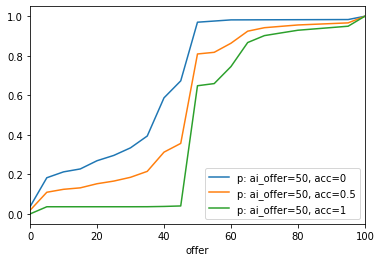

In [9]:
from core.utils.explanation import get_acceptance_probability
offers = list(range(0, MAX_GAIN+5, 5))
p_accepted_0 = np.zeros((len(offers)))
p_accepted_1 = np.zeros((len(offers)))
p_accepted_05 = np.zeros((len(offers)))
for idx, offer in enumerate(offers):
    p_accepted_0[idx] = get_acceptance_probability(50, offer, 0, infos["train_err_pdf"], experiment_mode=True, train_pdf=infos["pdf"])
    p_accepted_1[idx] = get_acceptance_probability(50, offer, 1, infos["train_err_pdf"], experiment_mode=True, train_pdf=infos["pdf"])
    p_accepted_05[idx] = get_acceptance_probability(50, offer, 0.5, infos["train_err_pdf"], experiment_mode=True, train_pdf=infos["pdf"])

lbl0 = "p: ai_offer=50, acc=0"
lbl1 = "p: ai_offer=50, acc=1"
lbl05 = "p: ai_offer=50, acc=0.5"
df = pd.DataFrame(data={"offer": offers, lbl0: p_accepted_0, lbl1: p_accepted_1, lbl05: p_accepted_05})
ax = df.plot(x="offer", y=[lbl0, lbl05, lbl1])

ax.figure.savefig(os.path.join(export_folder, "p-accepted.pdf"))

In [10]:
from core.utils.explanation import get_best_offer_probability
m = np.zeros((len(offers), len(offers)))
for idx_ai, ai_offer in enumerate(offers):
    for idx, offer in enumerate(offers):
        m[idx_ai][idx] = get_best_offer_probability(ai_offer, offer, infos["acc"], infos["train_err_pdf"], experiment_mode=True)

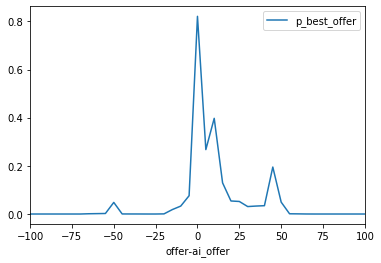

In [11]:
p_best_offer = np.convolve(infos["train_err_pdf"], [0.02, 0.03, 0.04, 0.9, 0.005, 0.003, 0.002], "same")
p_best_offer *= infos["acc"] / p_best_offer.max()
df = pd.DataFrame(data={"offer-ai_offer": infos["bins_train_err_pdf"][:-1], "p_best_offer": p_best_offer})
ax = df.plot(x="offer-ai_offer", y="p_best_offer")

ax.figure.savefig(os.path.join(export_folder, "p-best_offer.pdf"))

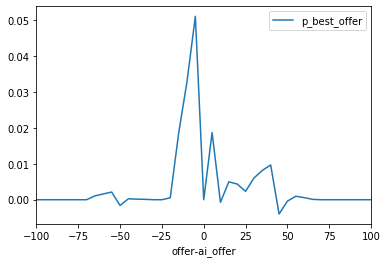

In [12]:
# p_best_offer = np.convolve(infos["train_err_pdf"], [0.02, 0.03, 0.04, 0.9, 0.005, 0.003, 0.002])
p_best_offer_raw = np.array(infos["train_err_pdf"])
p_best_offer_raw *= (infos["acc"] * 1.0) / p_best_offer_raw.max()
df = pd.DataFrame(data={"offer-ai_offer": infos["bins_train_err_pdf"][:-1], "p_best_offer": p_best_offer - p_best_offer_raw})
df.plot(x="offer-ai_offer", y="p_best_offer")

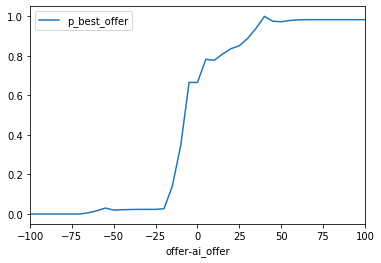

In [13]:
p_best_offer_raw = np.array(infos["train_err_pdf"])
p_best_offer_raw *= (infos["acc"] * 1.0) / p_best_offer_raw.max()
p = np.cumsum(p_best_offer - p_best_offer_raw)
p /= p.max()
df = pd.DataFrame(data={"offer-ai_offer": infos["bins_train_err_pdf"][:-1], "p_best_offer": p})
df.plot(x="offer-ai_offer", y="p_best_offer")

In [14]:
p_best_offer_raw

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04977052, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02488526,
       0.82121355, 0.24885259, 0.39816415, 0.1244263 , 0.04977052,
       0.04977052, 0.02488526, 0.02488526, 0.02488526, 0.19908207,
       0.04977052, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [15]:
infos.keys()

dict_keys(['test_gain_mean', 'test_avg_loss_ratio', 'val_gain_main', 'val_avg_loss_ratio', 'top_columns', 'pdf', 'bins_pdf', 'acc', 'val_acc', 'rel_acc_std', 'train_err_pdf', 'bins_train_err_pdf', 'unique_preds', 'df_min', 'df_max'])

In [16]:
np.log(1 + np.cumsum(p_best_offer_raw))

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04857159, 0.04857159, 0.04857159, 0.04857159, 0.04857159,
       0.04857159, 0.04857159, 0.04857159, 0.04857159, 0.0720004 ,
       0.63967748, 0.7630099 , 0.93329968, 0.98107136, 0.99955883,
       1.01771072, 1.02666458, 1.03553897, 1.04433531, 1.11205199,
       1.12828816, 1.12828816, 1.12828816, 1.12828816, 1.12828816,
       1.12828816, 1.12828816, 1.12828816, 1.12828816, 1.12828816,
       1.12828816])